# **Number of Claims Estimation with Generalized Additive Models (GAMs)**

Generalized Additive Models extend Generalized Linear Models in the systematic component that is made up by one parametric part and one non parametric part built by the sum of unknown "smoothing" functions of covariates. 

References:

-["Data Analytics for Non-Life Insurance Pricing"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2870308), Mario V. Wuthrich, Christoph Buser;

-["Statistical Foundations of Actuarial Learning and its Applications"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3822407), Mario V. Wuthrich, Michael Merz;

-["Case Study: French Motor Third-Party Liability Claims"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3164764), Mario V. Wuthrich, Alexander Noll, Robert Salzmann


# Upload Libraries

In [ ]:
# handling datasets
import numpy as np
import pandas as pd
# plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# modelling, evaluation
import sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.gam.api import GLMGam, BSplines
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


# Upload File

In [ ]:
from google.colab import files 
uploaded = files.upload()

Saving swmotorcycle_ClaimNb.csv to swmotorcycle_ClaimNb.csv


In [ ]:
# Reading File
df = pd.read_csv('swmotorcycle_ClaimNb.csv')

# Data Set Overview

In [ ]:
# Dimensions of data set
print(df.shape)

(64548, 8)


In [ ]:
# List types for each attribute
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64548 entries, 0 to 64547
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   OwnerAge    64548 non-null  int64  
 1   Gender      64548 non-null  object 
 2   Area        64548 non-null  object 
 3   RiskClass   64548 non-null  object 
 4   VehAge      64548 non-null  int64  
 5   BonusClass  64548 non-null  object 
 6   Exposure    64548 non-null  float64
 7   ClaimNb     64548 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 3.9+ MB
None


In [ ]:
# Take a peek at the first rows of the data
df.head()

,OwnerAge,Gender,Area,RiskClass,VehAge,BonusClass,Exposure,ClaimNb
0,0,Male,Central parts of Sweden's three largest cities,EV ratio 13-15,12,BM1,0.175342,0
1,4,Male,Lesser towns except Gotland; Northern towns,EV ratio 20-24,9,BM1,0.000000,0
2,5,Female,Lesser towns except Gotland; Northern towns,EV ratio 9-12,18,BM1,0.454795,0
3,5,Female,Small towns; countryside except Gotland; North...,EV ratio <5,25,BM1,0.172603,0
4,6,Female,Suburbs; middle-sized cities,EV ratio <5,26,BM1,0.180822,0


# Summary Statistics

In [ ]:
# Summarize attribute distributions for data type of variables
obj_cols = [var for var in df.columns if df[var].dtype=='object']
df[obj_cols].describe().T

,count,unique,top,freq
Gender,64548,2,Male,54695
Area,64548,7,Small towns; countryside except Gotland; North...,24816
RiskClass,64548,7,EV ratio 9-12,18905
BonusClass,64548,7,BM7,17953


In [ ]:
# Summarize attribute distributions for data type of variables
no_obj_cols = [var for var in df.columns if df[var].dtype!='object']
df[no_obj_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
OwnerAge,64548.0,42.416062,12.980960,0.0,31.000000,44.000000,52.0,92.00000
VehAge,64548.0,12.540063,9.727445,0.0,5.000000,12.000000,16.0,99.00000
Exposure,64548.0,1.010671,1.307424,0.0,0.463014,0.827397,1.0,31.33973
ClaimNb,64548.0,0.010798,0.107323,0.0,0.000000,0.000000,0.0,2.00000


# Data Cleaning

In [ ]:
# get number of unique values for each column
counts = df.nunique()
# record columns to delete
to_del = [i for i,v in enumerate(counts) if v == 1]
print(to_del)
# drop useless columns
df.drop(to_del, axis=1, inplace=True)
print(df.shape)

[]
(64548, 8)


In [ ]:
# get number of unique values for each row
counts = df.duplicated()
# record rows to delete
to_del = [i for i,v in enumerate(counts) if v == 1]
print(to_del)
print(df.shape)

[]
(64548, 8)


In [ ]:
# Check missing values both to numeric features and categorical features 
missing = df.isnull().sum()/df.shape[0]*100
missing

OwnerAge      0.0
Gender        0.0
Area          0.0
RiskClass     0.0
VehAge        0.0
BonusClass    0.0
Exposure      0.0
ClaimNb       0.0
dtype: float64

In [ ]:
# Feature transformation
df_1 = df.copy()
df_1['Exposure'] = df_1['Exposure'].clip(upper=1)
df_1['VehAge'] = df_1['VehAge'].clip(upper=20)

# Pre-Processing

In [ ]:
# Split dataset
df_train, df_test, = train_test_split(df_1, train_size=0.8, test_size=0.2,random_state=0)


In [ ]:
y_train = df_train.ClaimNb
y_test = df_test.ClaimNb
X_train = df_train.drop(['ClaimNb'], axis=1, inplace=False)
X_test = df_test.drop(['ClaimNb'], axis=1, inplace=False)

# Modelling 1

In [ ]:
np.random.seed(0)
x_spline = df_train[['OwnerAge','VehAge']]
bs = BSplines(x_spline, df=[5,5], degree=[3,3])
gam_poisson_1 = GLMGam.from_formula(formula='ClaimNb ~ C(Gender)+C(RiskClass)+C(Area)+C(BonusClass)', smoother=bs, data=df_train, offset=np.log1p(df_train['Exposure']), family=sm.families.Poisson(sm.families.links.log()))
gam_model_1 = gam_poisson_1.fit()
print(gam_model_1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:                51638
Model:                         GLMGam   Df Residuals:                    51610
Model Family:                 Poisson   Df Model:                        27.00
Link Function:                    log   Scale:                          1.0000
Method:                         PIRLS   Log-Likelihood:                -2747.3
Date:                Sun, 11 Sep 2022   Deviance:                       4434.4
Time:                        12:53:26   Pearson chi2:                 5.36e+04
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                                                                         coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

# Model Evaluation 1

In [ ]:
predictions_tr = gam_model_1.predict(exog = df_train[['Gender','RiskClass','Area','BonusClass']], exog_smooth = np.asarray(df_train[['OwnerAge', 'VehAge']]))
predictions_te = gam_model_1.predict(exog = df_test[['Gender','RiskClass','Area','BonusClass']], exog_smooth = np.asarray(df_test[['OwnerAge', 'VehAge']]))

In [ ]:
mean_poisson_deviance(y_train,predictions_tr)

0.08824900274224448

In [ ]:
mean_poisson_deviance(y_test,predictions_te)

0.0983717704085896

In [ ]:
np.sqrt(mean_squared_error(y_train, predictions_tr))

0.10521815721442125

In [ ]:
np.sqrt(mean_squared_error(y_test, predictions_te))

0.11252834327414507

# Modelling 2

In [ ]:
np.random.seed(0)
x_spline = df_train[['OwnerAge','VehAge']]
bs = BSplines(x_spline, df=[5,5], degree=[3,3])
gam_poisson_2 = GLMGam.from_formula(formula='ClaimNb ~ C(Gender)+C(RiskClass)+C(Area)', smoother=bs, data=df_train, offset=np.log1p(df_train['Exposure']), family=sm.families.Poisson(sm.families.links.log()))
gam_model_2 = gam_poisson_2.fit()
print(gam_model_2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:                51638
Model:                         GLMGam   Df Residuals:                    51616
Model Family:                 Poisson   Df Model:                        21.00
Link Function:                    log   Scale:                          1.0000
Method:                         PIRLS   Log-Likelihood:                -2766.5
Date:                Sun, 11 Sep 2022   Deviance:                       4472.7
Time:                        12:54:57   Pearson chi2:                 5.41e+04
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                                                                         coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

# Model Evaluation 2

In [ ]:
predictions_tr_ = gam_model_2.predict(exog = df_train[['Gender','RiskClass','Area']], exog_smooth = np.asarray(df_train[['OwnerAge', 'VehAge']]))
predictions_te_ = gam_model_2.predict(exog = df_test[['Gender','RiskClass','Area']], exog_smooth = np.asarray(df_test[['OwnerAge', 'VehAge']]))

In [ ]:
mean_poisson_deviance(y_train,predictions_tr_)

0.08912366925181825

In [ ]:
mean_poisson_deviance(y_test,predictions_te_)

0.10049585058240885

In [ ]:
np.sqrt(mean_squared_error(y_train, predictions_tr_))

0.10523599269479408

In [ ]:
np.sqrt(mean_squared_error(y_test, predictions_te_))

0.11267054689572446

# Modelling 3

In [ ]:
np.random.seed(0)
x_spline = df_train[['OwnerAge','VehAge']]
bs = BSplines(x_spline, df=[8,8], degree=[3,3])
gam_poisson_3 = GLMGam.from_formula(formula='ClaimNb ~ C(Gender)+C(RiskClass)+C(Area)+C(BonusClass)', smoother=bs, data=df_train, offset=np.log1p(df_train['Exposure']), family=sm.families.Poisson(sm.families.links.log()))
gam_model_3 = gam_poisson_3.fit()
print(gam_model_3.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:                51638
Model:                         GLMGam   Df Residuals:                 51604.00
Model Family:                 Poisson   Df Model:                        33.00
Link Function:                    log   Scale:                          1.0000
Method:                         PIRLS   Log-Likelihood:                -2743.3
Date:                Sun, 11 Sep 2022   Deviance:                       4426.3
Time:                        12:56:23   Pearson chi2:                 5.27e+04
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                                                                         coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

# Model Evaluation 3

In [ ]:
predictions_tr__ = gam_model_3.predict(exog = df_train[['Gender','RiskClass','Area','BonusClass']], exog_smooth = np.asarray(df_train[['OwnerAge', 'VehAge']]))
predictions_te__ = gam_model_3.predict(exog = df_test[['Gender','RiskClass','Area','BonusClass']], exog_smooth = np.asarray(df_test[['OwnerAge', 'VehAge']]))

In [ ]:
mean_poisson_deviance(y_train,predictions_tr__)

0.08806673675295365

In [ ]:
mean_poisson_deviance(y_test,predictions_te__)

0.09836667757684663

In [ ]:
np.sqrt(mean_squared_error(y_train, predictions_tr__))

0.10520065321184739

In [ ]:
np.sqrt(mean_squared_error(y_test, predictions_te__))

0.11253182441814917

# **GAM Results Analysis**

In [ ]:
coef = pd.DataFrame(np.exp(gam_model_3.params), columns = ['Value'])
coef

,Value
Intercept,6.173512e-03
C(Gender)[T.Male],2.066868e+00
C(RiskClass)[T.EV ratio 16-19],1.812976e+00
C(RiskClass)[T.EV ratio 20-24],2.473301e+00
C(RiskClass)[T.EV ratio 6-8],1.479412e+00
C(RiskClass)[T.EV ratio 9-12],1.262468e+00
C(RiskClass)[T.EV ratio <5],1.315392e+00
C(RiskClass)[T.EV ratio >25],7.153581e-01
C(Area)[T.Gotland (Sweden's largest island)],1.600849e-01
C(Area)[T.Lesser towns except Gotland; Northern towns],3.977452e-01


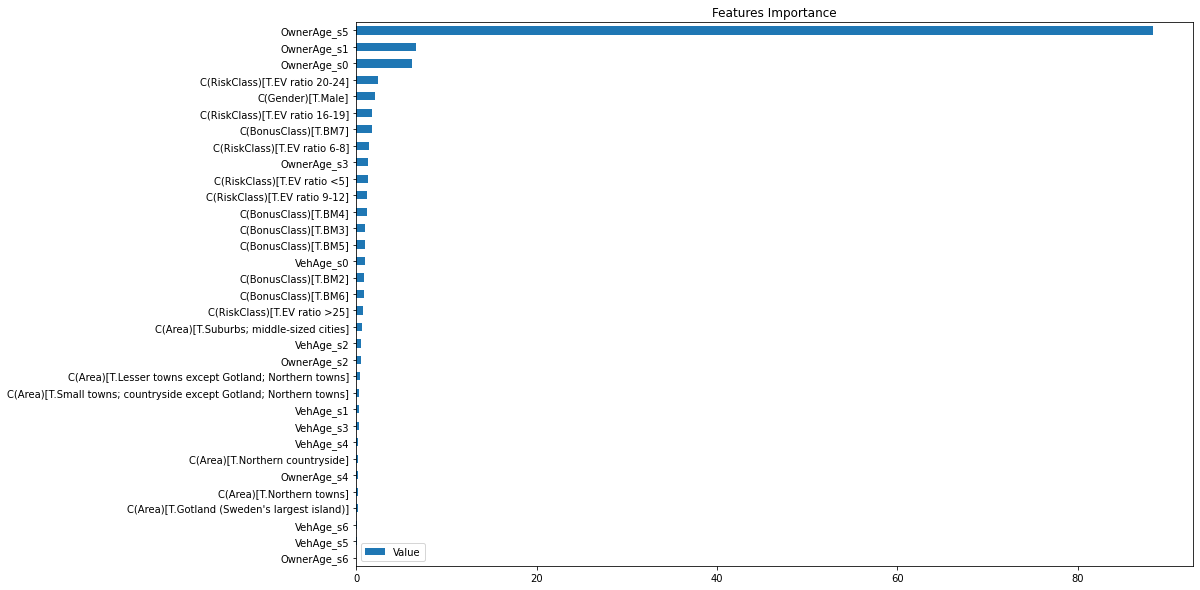

In [ ]:
# Features importance
coef_= coef.sort_values(by=['Value'])
coef.index.name="Coefficients"
coef_ = coef_.drop(['Intercept'])
plt.rcParams["figure.figsize"] = (15,10)
coef_.plot(kind='barh', use_index=True)
plt.title('Features Importance') 
plt.show()

In [ ]:
# attach predictions on test set
predictions_test = pd.DataFrame(predictions_te__, columns=['ClaimNb_pred'])
test = pd.concat([X_test, y_test,predictions_test], axis=1)
test

,OwnerAge,Gender,Area,RiskClass,VehAge,BonusClass,Exposure,ClaimNb,ClaimNb_pred
11551,28,Female,Small towns; countryside except Gotland; North...,EV ratio 20-24,13,BM3,0.419178,0,0.004725
27696,42,Female,Suburbs; middle-sized cities,EV ratio <5,4,BM7,0.983562,0,0.004107
56213,57,Male,Lesser towns except Gotland; Northern towns,EV ratio 13-15,16,BM7,1.000000,0,0.001852
8463,26,Male,Central parts of Sweden's three largest cities,EV ratio 13-15,13,BM1,0.986301,0,0.012467
35448,45,Male,Small towns; countryside except Gotland; North...,EV ratio 20-24,4,BM6,0.986301,0,0.005413
...,...,...,...,...,...,...,...,...,...
15776,31,Female,Lesser towns except Gotland; Northern towns,EV ratio 13-15,15,BM7,0.989041,0,0.002187
43435,49,Male,Small towns; countryside except Gotland; North...,EV ratio 13-15,11,BM7,1.000000,0,0.003472
50162,53,Male,Suburbs; middle-sized cities,EV ratio 9-12,6,BM7,1.000000,0,0.006650
2912,22,Male,Suburbs; middle-sized cities,EV ratio 16-19,8,BM1,0.630137,0,0.026422


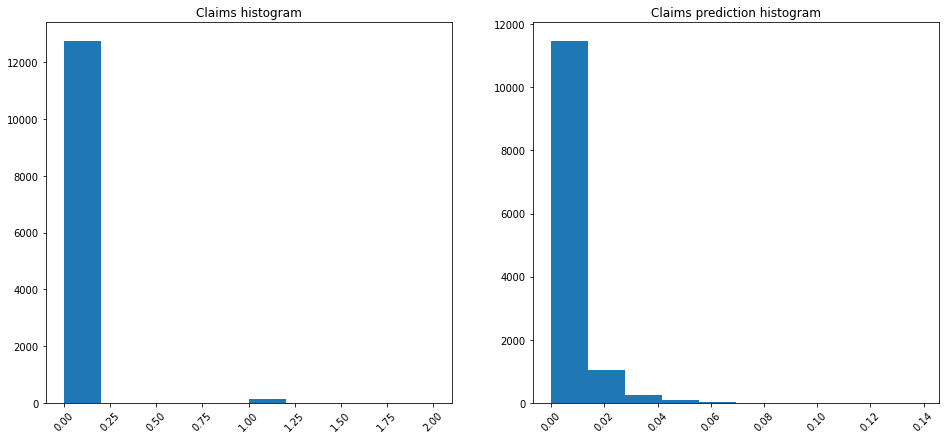

In [ ]:
# Claims and claims predicted comparison
fig = plt.figure(figsize = (16,7))
plt.subplot(1,2,1)  
plt.hist(test['ClaimNb'], bins=10)
plt.xticks(rotation=45)
plt.title('Claims histogram')
plt.subplot(1,2,2)  
plt.hist(test['ClaimNb_pred'], bins=10)
plt.xticks(rotation=45)
plt.title('Claims prediction histogram')
plt.show()

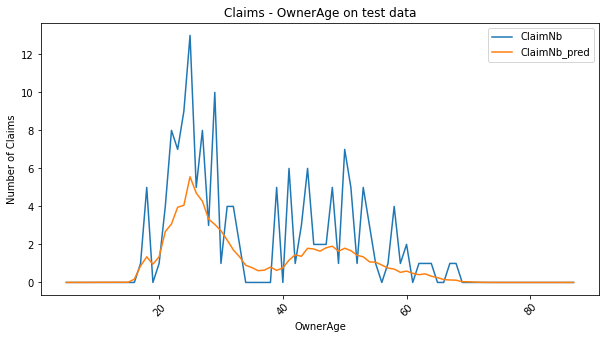

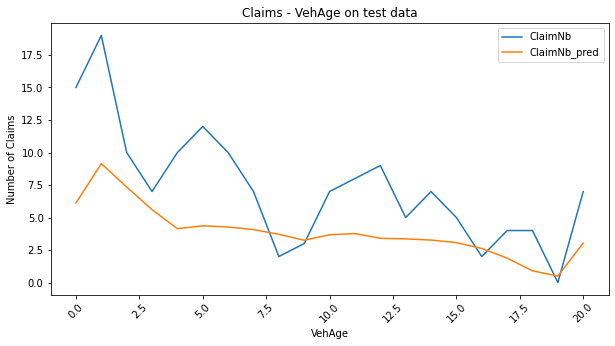

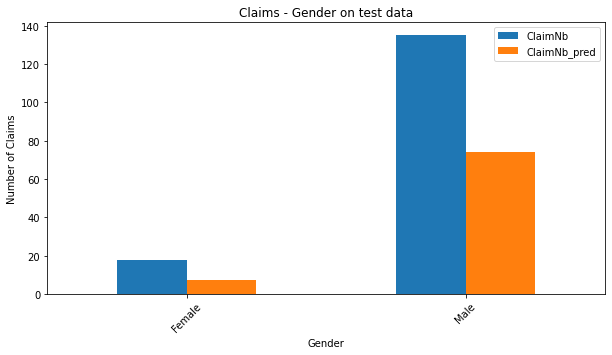

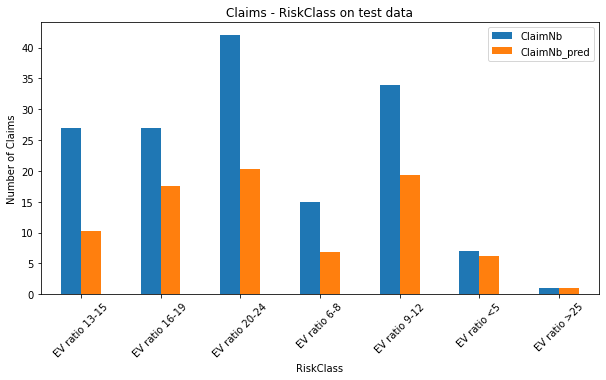

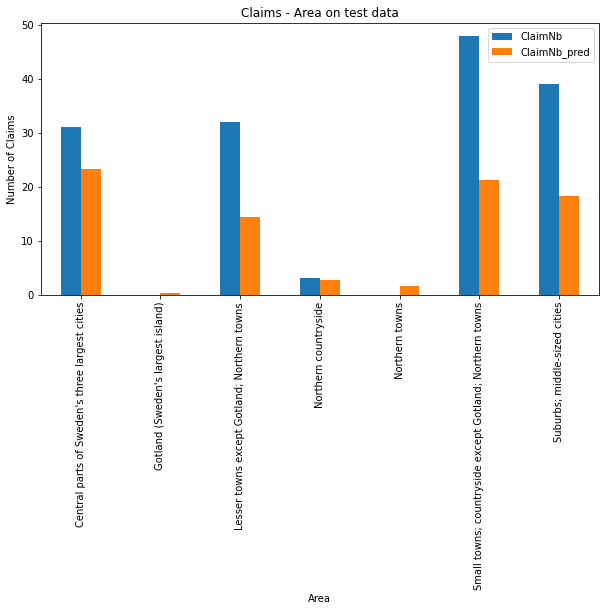

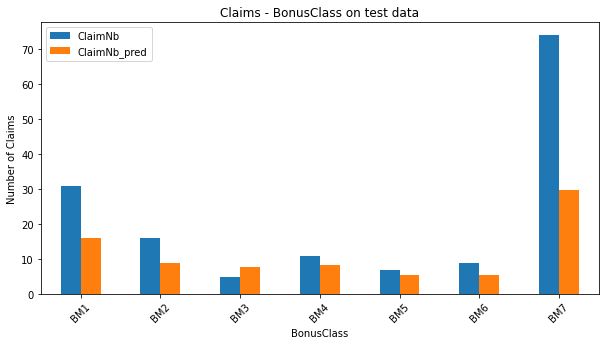

In [ ]:
# Claims and claims predicted comparison on features
plt.rcParams["figure.figsize"] = (10,5)
test_group_oa = test.groupby(['OwnerAge'])['ClaimNb','ClaimNb_pred'].sum().reset_index()
test_group_oa.plot(x='OwnerAge',y= ['ClaimNb','ClaimNb_pred'])
plt.xticks(rotation=45)
plt.ylabel('Number of Claims')
plt.xlabel('OwnerAge')
plt.title('Claims - OwnerAge on test data')
plt.show()
test_group_va = test.groupby(['VehAge'])['ClaimNb','ClaimNb_pred'].sum().reset_index()
test_group_va.plot(x='VehAge',y= ['ClaimNb','ClaimNb_pred'])
plt.xticks(rotation=45)
plt.ylabel('Number of Claims')
plt.xlabel('VehAge')
plt.title('Claims - VehAge on test data')
plt.show()
test_group_ge = test.groupby(['Gender'])['ClaimNb','ClaimNb_pred'].sum().reset_index()
test_group_ge.plot.bar(x='Gender',y= ['ClaimNb','ClaimNb_pred'])
plt.xticks(rotation=45)
plt.ylabel('Number of Claims')
plt.xlabel('Gender')
plt.title('Claims - Gender on test data')
plt.show()
test_group_rc = test.groupby(['RiskClass'])['ClaimNb','ClaimNb_pred'].sum().reset_index()
test_group_rc.plot.bar(x='RiskClass',y= ['ClaimNb','ClaimNb_pred'])
plt.xticks(rotation=45)
plt.ylabel('Number of Claims')
plt.xlabel('RiskClass')
plt.title('Claims - RiskClass on test data')
plt.show()
test_group_a = test.groupby(['Area'])['ClaimNb','ClaimNb_pred'].sum().reset_index()
test_group_a.plot.bar(x='Area',y= ['ClaimNb','ClaimNb_pred'])
plt.xticks(rotation=90)
plt.ylabel('Number of Claims')
plt.xlabel('Area')
plt.title('Claims - Area on test data')
plt.show()
test_group_bc = test.groupby(['BonusClass'])['ClaimNb','ClaimNb_pred'].sum().reset_index()
test_group_bc.plot.bar(x='BonusClass',y= ['ClaimNb','ClaimNb_pred'])
plt.xticks(rotation=45)
plt.ylabel('Number of Claims')
plt.xlabel('BonusClass')
plt.title('Claims - BonusClass on test data')
plt.show()

